## Введение в CNN, классификация изображений

План:
1. Иллюстрация применения свёртки к изображению
2. `nn.Conv2D` и параметры
3. Max pooling, Average pooling, `nn.MaxPool2D`

In [1]:
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
from PIL import Image
from torch import nn
from torchvision import transforms

### 1. Свёртка

<img src="../assets/images/conv-pad.svg" style="background:white" width="400"/>

In [2]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)
for k, v in conv.named_parameters():
    print(k, v)

weight Parameter containing:
tensor([[[[-0.3833, -0.1216],
          [ 0.3109,  0.2851]]]], requires_grad=True)
bias Parameter containing:
tensor([-0.3964], requires_grad=True)


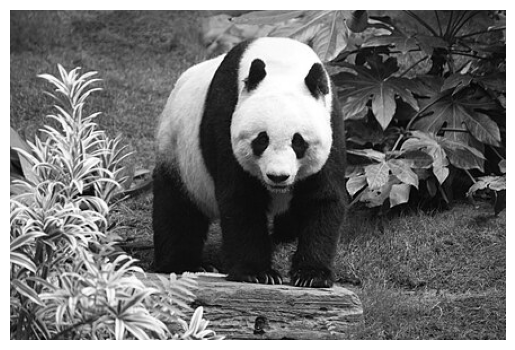

In [3]:
# IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/440px-Grosser_Panda.JPG"

# img = Image.open(requests.get(IMAGE_URL, stream=True).raw)
img = Image.open("../assets/images/panda.jpg")
grayscale = img.convert("L")

plt.imshow(grayscale, cmap="gray")
plt.axis(False)
plt.show()

Зададим несколько фильтров. Что они делают?

In [4]:
filters = {
    "0": torch.tensor([[[
        [ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  0,  0],
    ]]], dtype=torch.float),
    "1": torch.tensor([[[
        [ 0, -1,  0],
        [-1,  4, -1],
        [ 0, -1,  0],
    ]]], dtype=torch.float),
    "2": torch.tensor([[[
        [ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0],
    ]]], dtype=torch.float),
    "3": torch.tensor([[[
        [ 1,  2,  1],
        [ 2,  4,  2],
        [ 1,  2,  1],
    ]]], dtype=torch.float) / 16,
}

Посмотрим на результаты:

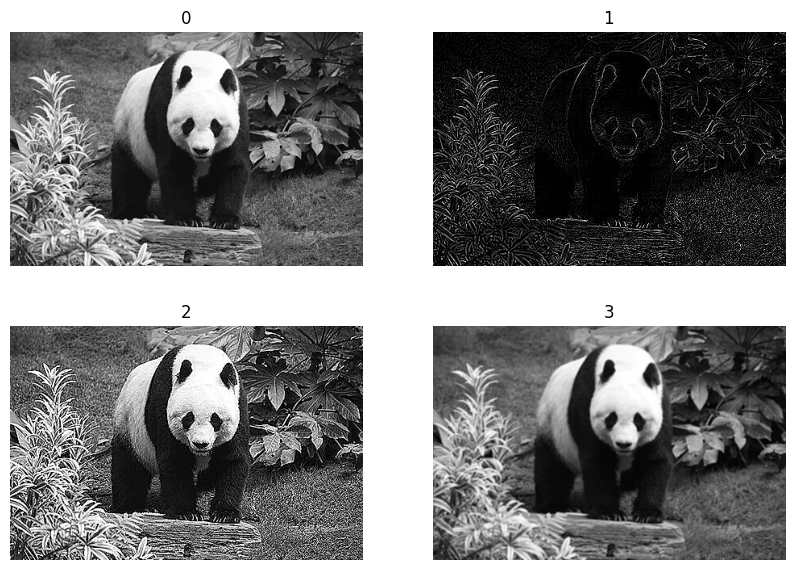

In [5]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 7))

# Создадим свёрточный слой и преобразуем изображение в тензор
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
img_tensor = transforms.ToTensor()(grayscale)

for k, (filter_name, filter_kernel) in enumerate(filters.items()):
    # подставим значения для фильтра в свёрточный слой
    conv.weight.data = filter_kernel

    # преобразуем входное изображение и обрежем до отрезка [0, 1] для корректного отображения
    transformed = conv(img_tensor).detach().numpy()[0].clip(0, 1)
    row = k // ncols
    column = k % ncols
    ax = axes[row][column]
    ax.imshow(transformed, cmap="gray")
    ax.set_title(filter_name)
    ax.set_axis_off()

plt.show()

### 2. `nn.Conv2D`

Свёртка входного тензора размера $(N, C_{\text{in}}, H, W)$ в тензор размера $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$ описывается так:

<!-- In the simplest case, the output value of the layer with input size
$(N, C_{\text{in}}, H, W)$ and output $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$    can be precisely described as: -->
    
$$\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) + \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)$$

$\star$ - 2D оператор кросс-корреляции, $N$ - размер батча, $C$ - количество каналов, $H$ и $W$ - высота и ширина в пикселах соответственно

<!-- $\star$ is the valid 2D `cross-correlation`_ operator,$N$ is a batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels. -->

Каждый `nn.Conv2D` слой содержит две группы параметров:
- `weight`: тензор размера $(C_{out}, C_{in}, H_k, W_k)$
  - $C_{in}$: количество входных каналов
  - $C_{out}$: количество выходных каналов
  - $(H_k, W_k)$: размер 2D кернела (например, $3 \times 3$)
- `bias`: тензор размера $(C_{out},)$

Кроме того, регулировать количество параметров можно с помощью аргументов конструктора
- `bias (bool)`: включение / отключения параметра сдвига
- `groups`: число групп, на которые следует разбить входные и выходные каналы; каждый фильтр работает только с одной группой каналов

![GroupConv](https://www.researchgate.net/publication/351823568/figure/fig2/AS:1027082138181632@1621886872538/Standard-convolution-left-and-group-convolution-right.ppm)

**Упражнение**: сколько параметров будет в свёрточном слое с размером кернела $3 \times 3$ для преобразования тензора с 3 каналами в тензор с 6 каналами без группировки? С разделением на 3 группы?

Другие параметры, влияющие на результат свёртки
- `stride`: каков размер смещения между соседними срезами, к которым применяется свёртка
- `padding`: как дополнить входной тензор пикселами вокруг
- `dilation`: позволяет взять не связный срез, а растянутый, с просветом между пикселами

Демо: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/arbitrary_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/same_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/full_padding_no_strides.gif?raw=true"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides_odd.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/dilation.gif?raw=true"></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td>No padding, no stride, dilation</td>
  </tr>
</table>



### 3. Max pooling

![maxpool](../assets/images/maxpool.png)

Параметры инициализации `nn.MaxPool2d` (а так же `nn.AvgPool2d`) похожи на свёрточный слой:
- `kernel_size`: размер 2D кернела (обычно $2 \times 2$)
- `stride`: каков размер смещения между соседними срезами, к которым применяется pooling (обычно 2, т.е. без наложения)
- `padding`: как дополнить входной тензор пикселами вокруг
- `dilation`: позволяет взять не связный срез, а растянутый, с просветом между пикселами

In [6]:
x = torch.tensor([
    [ 12,  20, 30,  0],
    [  8,  12,  2,  0],
    [ 34,  70, 37,  4],
    [112, 100, 25, 12],
]).unsqueeze(0)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
pool(x)


tensor([[[ 20,  30],
         [112,  37]]])

Характерный строительный блок для свёрточной сети:
- `Conv -> ReLU -> MaxPool`
- В каждом следующем блоке размер активаций уменьшается (обычно в 4 раза), размер каналов увеличивается

Для того, чтобы перед линейным слоем размер активаций был одинаковым для любого размера входного изображения, есть `nn.AdaptiveMaxPool2d`

In [7]:
pool = nn.AdaptiveMaxPool2d(output_size=(2, 1))
pool(x.float())

tensor([[[ 30.],
         [112.]]])